In [2]:
import torch
#import jovian
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split

In [218]:
data=pd.read_csv('/content/datasets_229906_491820_Fish.csv')
data.head(11)

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340
5,Bream,450.0,26.8,29.7,34.7,13.6024,4.9274
6,Bream,500.0,26.8,29.7,34.5,14.1795,5.2785
7,Bream,390.0,27.6,30.0,35.0,12.6700,4.6900
8,Bream,450.0,27.6,30.0,35.1,14.0049,4.8438
9,Bream,500.0,28.5,30.7,36.2,14.2266,4.9594


In [173]:
data.shape

(159, 7)

In [180]:
num_rows = data.shape[0]
print(num_rows)

159


In [181]:
num_cols = data.shape[1]
print(num_cols)

7


In [182]:
data.describe()

,Weight,Length1,Length2,Length3,Height,Width
count,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000
mean,398.326415,26.247170,28.415723,31.227044,8.970994,4.417486
std,357.978317,9.996441,10.716328,11.610246,4.286208,1.685804
min,0.000000,7.500000,8.400000,8.800000,1.728400,1.047600
25%,120.000000,19.050000,21.000000,23.150000,5.944800,3.385650
50%,273.000000,25.200000,27.300000,29.400000,7.786000,4.248500
75%,650.000000,32.700000,35.500000,39.650000,12.365900,5.584500
max,1650.000000,59.000000,63.400000,68.000000,18.957000,8.142000


In [183]:
data.columns

Index(['Species', 'Weight', 'Length1', 'Length2', 'Length3', 'Height',
       'Width'],
      dtype='object')

In [184]:
input_cols = list(data.columns.values)
input_cols.remove('Weight')
print(input_cols)

['Species', 'Length1', 'Length2', 'Length3', 'Height', 'Width']


In [185]:
output_cols=['Weight']
print(output_cols)

['Weight']


In [186]:
categorical_cols = data.select_dtypes('object').columns.to_list()
print(categorical_cols)

['Species']


In [187]:
def dataframe_to_arrays(dataframe):
    # Make a copy of the original dataframe
    data1 = data.copy(deep=True)
    # Convert non-numeric categorical columns to numbers
    for col in categorical_cols:
        data1[col] = data1[col].astype('category').cat.codes
    # Extract input & outupts as numpy arrays
    inputs_array = data1[input_cols].to_numpy()
    targets_array = data1[output_cols].to_numpy()
    return inputs_array, targets_array

In [ ]:
inputs_array, targets_array = dataframe_to_arrays(data)
inputs_array, targets_array

In [ ]:
inputs = torch.from_numpy(inputs_array).type(torch.float32)
targets = torch.from_numpy(targets_array).type(torch.float32)

inputs,targets

In [190]:
inputs.dtype, targets.dtype

(torch.float32, torch.float32)

In [217]:
dataset = TensorDataset(inputs, targets)
dataset

In [192]:
val_percent = 0.1 # between 0.1 and 0.2
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size



In [193]:
train_ds, val_ds =  random_split(dataset, [train_size, val_size])# Use the random_split function to split dataset into 2 parts 

In [194]:
batch_size =50
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

In [ ]:
for xb, yb in train_loader:
    print("inputs:", xb)
    print("targets:", yb)
    break

In [196]:
input_size = len(input_cols)
output_size = len(output_cols)

In [197]:
class FishModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)                # fill this (hint: use input_size & output_size defined above)
        
    def forward(self, xb):
        out = self.linear(xb)                          # fill this
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)          
        # Calcuate loss
        loss = F.smooth_l1_loss(out, targets)                         # fill this
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = F.smooth_l1_loss(out, targets)                     # fill this    
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 20 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

In [198]:
model = FishModel()

In [199]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.2558, -0.3410,  0.2190, -0.3502, -0.1969, -0.1701]],
        requires_grad=True), Parameter containing:
 tensor([-0.3320], requires_grad=True)]

In [200]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

In [201]:
result = evaluate(model,val_loader) # Use the the evaluate function
print(result)

{'val_loss': 262.54754638671875}


In [202]:
model = FishModel()
epochs = 1000
lr = 1e-2
history1 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 155.8530
Epoch [40], val_loss: 157.1553
Epoch [60], val_loss: 158.4502
Epoch [80], val_loss: 158.5348
Epoch [100], val_loss: 157.3562
Epoch [120], val_loss: 152.3236
Epoch [140], val_loss: 149.8109
Epoch [160], val_loss: 148.5622
Epoch [180], val_loss: 147.0298
Epoch [200], val_loss: 145.8475
Epoch [220], val_loss: 145.2064
Epoch [240], val_loss: 142.4514
Epoch [260], val_loss: 141.9834
Epoch [280], val_loss: 140.1480
Epoch [300], val_loss: 139.3102
Epoch [320], val_loss: 138.3080
Epoch [340], val_loss: 137.9448
Epoch [360], val_loss: 137.2812
Epoch [380], val_loss: 135.4478
Epoch [400], val_loss: 133.6426
Epoch [420], val_loss: 131.5057
Epoch [440], val_loss: 130.8364
Epoch [460], val_loss: 130.4005
Epoch [480], val_loss: 130.0632
Epoch [500], val_loss: 130.0703
Epoch [520], val_loss: 128.4687
Epoch [540], val_loss: 129.7551
Epoch [560], val_loss: 129.1335
Epoch [580], val_loss: 129.3008
Epoch [600], val_loss: 129.9254
Epoch [620], val_loss: 129.5931
Epoch [640],

In [ ]:
model = FishModel()
epochs = 1000
lr = 1e-3
history2 = fit(epochs, lr, model, train_loader, val_loader)

In [ ]:
model = FishModel()
epochs = 1000
lr = 1e-4
history3 = fit(epochs, lr, model, train_loader, val_loader)

In [ ]:
model = FishModel()
epochs = 1000
lr = 1e-4
history4 = fit(epochs, lr, model, train_loader, val_loader)

In [ ]:
model = FishModel()
epochs = 1000
lr = 1e-5
history5 = fit(epochs, lr, model, train_loader, val_loader)

Text(0.5, 1.0, 'validation loss')

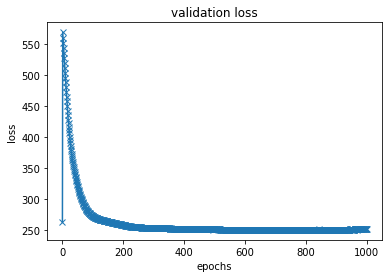

In [216]:
val_loss = [r['val_loss'] for r in [result] + history2]
plt.plot(val_loss, '-x')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.title('validation loss')

In [204]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)               # fill this #model(inputs)
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)

In [214]:
input, target = val_ds[7]
predict_single(input, target, model)

Input: tensor([ 3.0000, 40.0000, 42.5000, 45.5000,  7.2800,  4.3225])
Target: tensor([456.])
Prediction: tensor([505.9505])


In [207]:
input, target = val_ds[10]

predict_single(input, target, model)

Input: tensor([ 5.0000, 11.3000, 11.8000, 13.1000,  2.2139,  1.1659])
Target: tensor([9.9000])
Prediction: tensor([13.0508])
